In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


df = pd.read_csv("homelens_temsili_veri.csv")
df.head()


,Semt,Oda_Sayisi,Metrekare,Bina_Yasi,Kat,Isitma,Site_Icinde,Esyali,Asansor,Balkon,Manzara,Aidat,Kira
0,Karşıyaka,2+1,142,17,4,Klima,Evet,Hayır,Evet,Evet,Şehir,243,34156
1,Bayraklı,2+1,111,14,1,Klima,Evet,Evet,Hayır,Evet,Şehir,584,22746
2,Bornova,1+1,139,10,1,Doğalgaz Kombi,Hayır,Evet,Evet,Evet,Deniz,211,28713
3,Konak,2+1,112,13,3,Klima,Hayır,Hayır,Hayır,Hayır,Yok,721,22354
4,Bornova,1+1,114,19,3,Doğalgaz Kombi,Evet,Evet,Evet,Evet,Deniz,55,26047


In [17]:
X = df.drop("Kira", axis=1)
y = df["Kira"]


In [18]:
sayisal_sutunlar = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Sayısal sütunlar:", sayisal_sutunlar)
print("Kategorik sütunlar:", kategorik_sutunlar)


Sayısal sütunlar: ['Metrekare', 'Bina_Yasi', 'Kat', 'Aidat']
Kategorik sütunlar: ['Semt', 'Oda_Sayisi', 'Isitma', 'Site_Icinde', 'Esyali', 'Asansor', 'Balkon', 'Manzara']


In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), kategorik_sutunlar)
    ],
    remainder="passthrough"
)


In [20]:
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

param_grid = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}


In [21]:
gs = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(X, y)

print("En iyi RMSE:", np.sqrt(-gs.best_score_))
print("En iyi parametreler:", gs.best_params_)


En iyi RMSE: 1301.4515249643378
En iyi parametreler: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [22]:
def plot_learning_curve(estimator, X, y, title):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_rmse.mean(axis=1), label='Training RMSE')
    plt.plot(train_sizes, val_rmse.mean(axis=1), label='Validation RMSE')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()


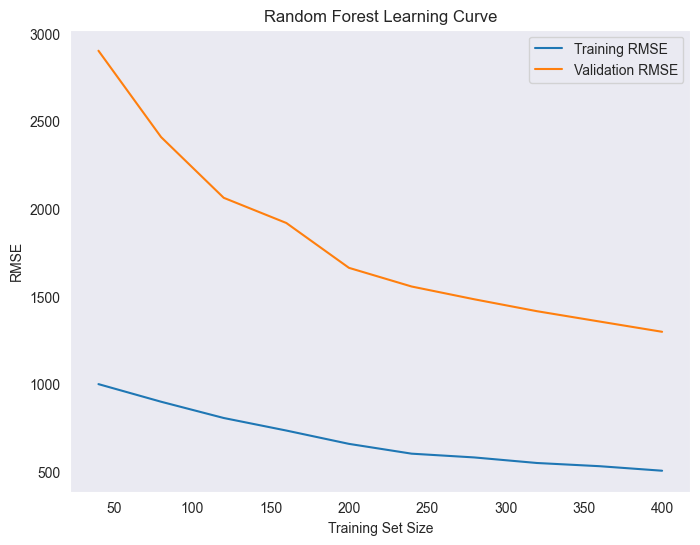

In [23]:
plot_learning_curve(gs.best_estimator_, X, y, "Random Forest Learning Curve")


In [24]:
best_rf_model = gs.best_estimator_
joblib.dump(best_rf_model, 'rf_model.pkl')

['rf_model.pkl']